In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib.pylab import plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/CS3244 Project')
os.chdir('Dataset/')

# Read in Data

In [ ]:
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('train_reduced.csv')
df_test = pd.read_csv('test_reduced.csv')

# Separate the feature columns (x) from the target column (y) in both DataFrames
X_train = df_train.drop('target', axis=1)
X_train = X_train.drop('ID', axis=1)
y_train = df_train['target']
#further split training data into train and validation:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size = 0.15,
                                                      random_state = 42)

X_test = df_test.drop('target', axis=1)
X_test = X_test.drop('ID', axis=1)
y_test = df_test['target']

print(X_train.columns)
print('Training data counts: ', X_train.shape)
print('Proportion of good and bad accounts in training data: \n', y_train.value_counts())
print('Validation data counts: ', X_valid.shape)
print('Proportion of good and bad accounts in validation data: \n', y_valid.value_counts())
print('Testing data counts: ', X_test.shape)
print('Proportion of good and bad accounts in testing data: \n', y_test.value_counts())

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'EMPLOYED', 'LONG_TERM_UNEMPLOYED',
       'MARRIAGE_STATUS', 'EDUCATION', 'WAY_OF_LIVING', 'age_bins',
       'RATIO_EMPLOYED', 'Age_Children_Interaction', 'debt_to_income_ratio',
       'stable_employment', 'occupation_type_frequency',
       'occupation_mean_income', 'income_percentile_by_housing'],
      dtype='object')
Training data counts:  (24786, 19)
Proportion of good and bad accounts in training data: 
 1    16788
0     7998
Name: target, dtype: int64
Validation data counts:  (4374, 19)
Proportion of good and bad accounts in validation data: 
 1    2955
0    1419
Name: target, dtype: int64
Testing data counts:  (7291, 19)
Proportion of good and bad accounts in testing data: 
 1    4938
0    2353
Name: target, dtype: int64


1 refer to good and 0 refer to bad accounts. Bank incur a lot of losses when they accept bad accounts who accumulate bad debts and default. Hence, it is very crucial for our model to be able to be precise.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)
X_valid, y_valid = ros.fit_resample(X_valid, y_valid)
X_test, y_test = ros.fit_resample(X_test, y_test)

print('Proportion of good and bad accounts in training data: \n', y_train.value_counts())
print('Proportion of good and bad accounts in validation data: \n', y_valid.value_counts())
print('Proportion of good and bad accounts in testing data: \n', y_test.value_counts())

Proportion of good and bad accounts in training data: 
 1    16788
0    16788
Name: target, dtype: int64
Proportion of good and bad accounts in validation data: 
 0    2955
1    2955
Name: target, dtype: int64
Proportion of good and bad accounts in testing data: 
 0    4938
1    4938
Name: target, dtype: int64


# Modelling

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Function to evaluate the model and print metrics
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_valid)

    # Print accuracy
    print('Accuracy on validation set: {:.8f}'.format(accuracy_score(y_valid, y_pred)))

    # Print confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print('True Neg:', tn, '\t' ,'False Pos:', fp)
    print('False Neg:', fn, '\t', 'True Pos:', tp)

    # Print precision and recall
    print('Precision on validation set: {:.8f}'.format(precision_score(y_valid, y_pred)))
    print('Recall on validation set: {:.8f}'.format(recall_score(y_valid, y_pred)))
    print('F1-Score on validation set: {:.8f}'.format(f1_score(y_valid, y_pred)))


    # Plot ROC Curve
    try:
        class_prob = model.predict_proba(X_valid)
        preds = class_prob[:, 1]
        fpr, tpr, threshold = roc_curve(y_valid, preds)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='Model (area = %0.5f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    except AttributeError:
        print("Model does not have predict_proba method. ROC curve not plotted.")


## Logistic Regression

Accuracy on validation set: 0.49949239
True Neg: 1701 	 False Pos: 1254
False Neg: 1704 	 True Pos: 1251
Precision on validation set: 0.49940120
Recall on validation set: 0.42335025
F1-Score on validation set: 0.45824176


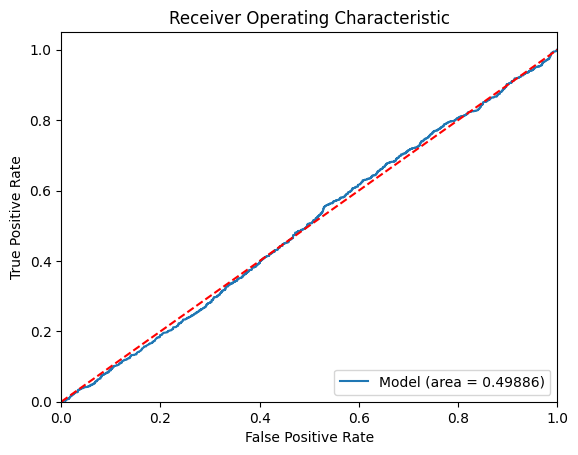

In [ ]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
evaluate_model(logReg, X_train, y_train, X_valid, y_valid)

### Weighted Logistic Regression

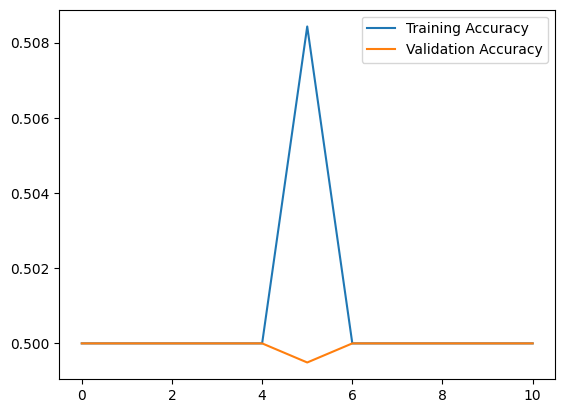

In [ ]:
logwt_trainaccuracy = np.zeros(shape=(11))
logwt_testaccuracy = np.zeros(shape=(11))

for weight in range(0, 11):
  wt = 0.1*weight
  wts = {0:wt, 1:1-wt}
  logwt = LogisticRegression(class_weight = wts)
  logwt.fit(X_train,y_train)
  logwt_trainaccuracy[weight]= logwt.score(X_train, y_train)
  logwt_testaccuracy[weight]= logwt.score(X_valid, y_valid)

depths = range(0, 11)

# Plot and label the training and validation loss values
plt.plot(depths, logwt_trainaccuracy, label='Training Accuracy')
plt.plot(depths, logwt_testaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

Tried weighted logistic regression but it predicts the class with higher weights. (ie. sharp drop after 6 => class weights {0: 0.6, 1: 0.4} which causes the model to predict all as 0 and we have about 1/3 33% of 0 classes)

### Feature Selection Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

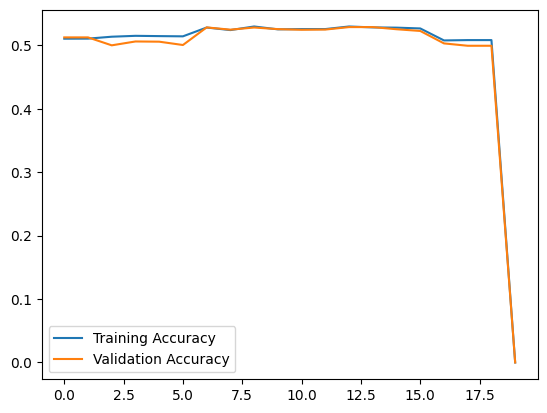

In [ ]:
from sklearn.feature_selection import RFE

train_acc = np.zeros(shape=(20))
valid_acc = np.zeros(shape=(20))


for i in range(1, 20):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_train,y_train)
    train_acc[i - 1]= rfe.score(X_train, y_train)
    valid_acc[i - 1]= rfe.score(X_valid, y_valid)

depths = range(20)

# Plot and label the training and validation loss values
plt.plot(depths, train_acc, label='Training Accuracy')
plt.plot(depths, valid_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

13


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on validation set: 0.52893401
True Neg: 1511 	 False Pos: 1444
False Neg: 1340 	 True Pos: 1615
Precision on validation set: 0.52795031
Recall on validation set: 0.54653130
F1-Score on validation set: 0.53708015


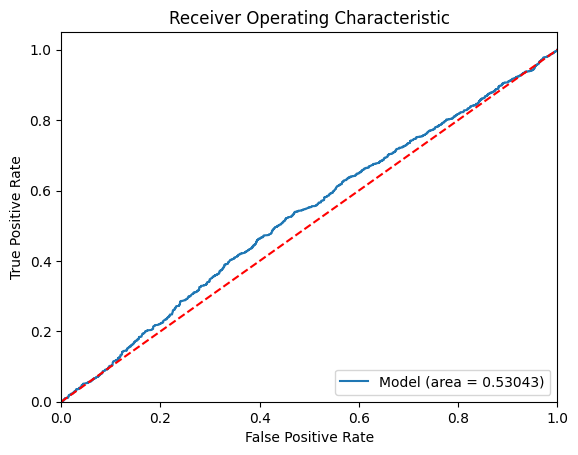

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'EMPLOYED', 'LONG_TERM_UNEMPLOYED', 'MARRIAGE_STATUS',
       'EDUCATION', 'age_bins', 'RATIO_EMPLOYED', 'stable_employment',
       'income_percentile_by_housing'],
      dtype='object')


In [ ]:
d = valid_acc.argmax(axis=0) + 1
print(d)
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=d)
evaluate_model(rfe, X_train, y_train, X_valid, y_valid)

print(X_train.columns[rfe.support_])


## Ridge Regression

In [ ]:
from sklearn.linear_model import RidgeClassifier

ridgeClass = RidgeClassifier()
evaluate_model(ridgeClass, X_train, y_train, X_valid, y_valid)

Accuracy on validation set: 0.52571912
True Neg: 1499 	 False Pos: 1456
False Neg: 1347 	 True Pos: 1608
Precision on validation set: 0.52480418
Recall on validation set: 0.54416244
F1-Score on validation set: 0.53430802
Model does not have predict_proba method. ROC curve not plotted.


In [ ]:
from sklearn.feature_selection import RFE
model = RidgeClassifier()
rfe = RFE(model, n_features_to_select=13)
evaluate_model(rfe, X_train, y_train, X_valid, y_valid)

print(X_train.columns[rfe.support_])

Accuracy on validation set: 0.52741117
True Neg: 1504 	 False Pos: 1451
False Neg: 1342 	 True Pos: 1613
Precision on validation set: 0.52643603
Recall on validation set: 0.54585448
F1-Score on validation set: 0.53596943
Model does not have predict_proba method. ROC curve not plotted.
Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'EMPLOYED', 'MARRIAGE_STATUS', 'EDUCATION', 'age_bins',
       'RATIO_EMPLOYED', 'debt_to_income_ratio', 'stable_employment',
       'income_percentile_by_housing'],
      dtype='object')


Still the problem of just predicting positive for all of the data points.

## Decision Tree

Accuracy on validation set: 0.64500846
True Neg: 1894 	 False Pos: 1061
False Neg: 1037 	 True Pos: 1918
Precision on validation set: 0.64384021
Recall on validation set: 0.64906937
F1-Score on validation set: 0.64644422


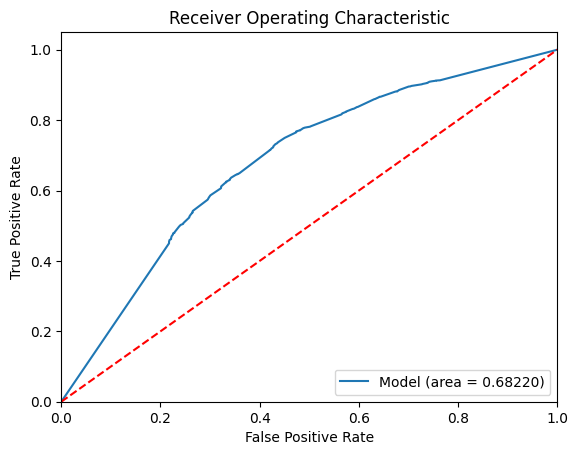

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
evaluate_model(tree, X_train, y_train, X_valid, y_valid)

### Max-Depth Decision Tree

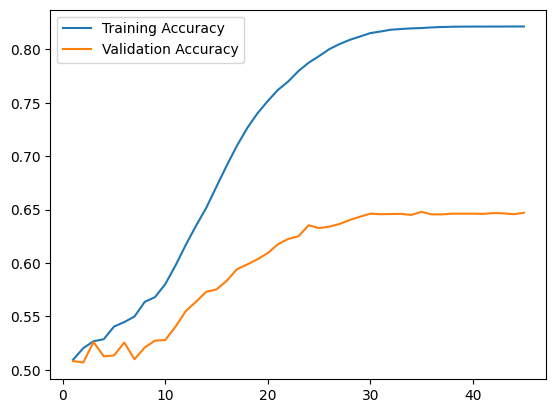

In [ ]:
tree_trainaccuracy = np.zeros(shape=(tree.tree_.max_depth))
tree_validaccuracy = np.zeros(shape=(tree.tree_.max_depth))
for max_d in range(1,tree.tree_.max_depth+1):
  tree2 = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  tree2.fit(X_train,y_train)
  tree_trainaccuracy[max_d - 1]= tree2.score(X_train, y_train)
  tree_validaccuracy[max_d - 1]= tree2.score(X_valid, y_valid)

depths = range(1, tree.tree_.max_depth+1)

# Plot and label the training and validation loss values
plt.plot(depths, tree_trainaccuracy, label='Training Accuracy')
plt.plot(depths, tree_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

35


Accuracy on validation set: 0.64754653
True Neg: 1923 	 False Pos: 1032
False Neg: 1051 	 True Pos: 1904
Precision on validation set: 0.64850136
Recall on validation set: 0.64433164
F1-Score on validation set: 0.64640978


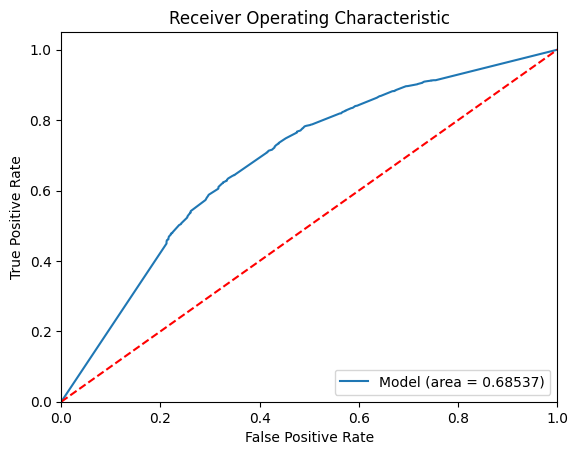

In [ ]:
# max_depth = sqrt(d)
d = tree_validaccuracy.argmax(axis=0) + 1
print(d)
tree_depth = DecisionTreeClassifier(max_depth=d)
evaluate_model(tree_depth, X_train, y_train, X_valid, y_valid)

Validation accuracy peaks at 34.

### Feature Selection Decision Tree

Index(['RATIO_EMPLOYED', 'Age_Children_Interaction',
       'occupation_type_frequency', 'occupation_mean_income',
       'income_percentile_by_housing'],
      dtype='object')
Accuracy on validation set: 0.62402707
True Neg: 1735 	 False Pos: 1220
False Neg: 1002 	 True Pos: 1953
Precision on validation set: 0.61550583
Recall on validation set: 0.66091371
F1-Score on validation set: 0.63740209


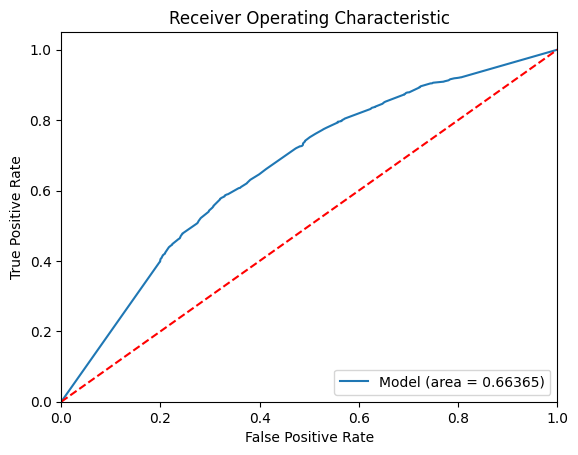

In [ ]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(DecisionTreeClassifier())
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

newX_train = X_train[selected_feat]
newX_valid = X_valid[selected_feat]

dt_feat = DecisionTreeClassifier()
evaluate_model(dt_feat, newX_train, y_train, newX_valid, y_valid)

Not much improvement with feature selection.

## Random Forest

Accuracy on validation set: 0.64534687
True Neg: 1895 	 False Pos: 1060
False Neg: 1036 	 True Pos: 1919
Precision on validation set: 0.64417590
Recall on validation set: 0.64940778
F1-Score on validation set: 0.64678126


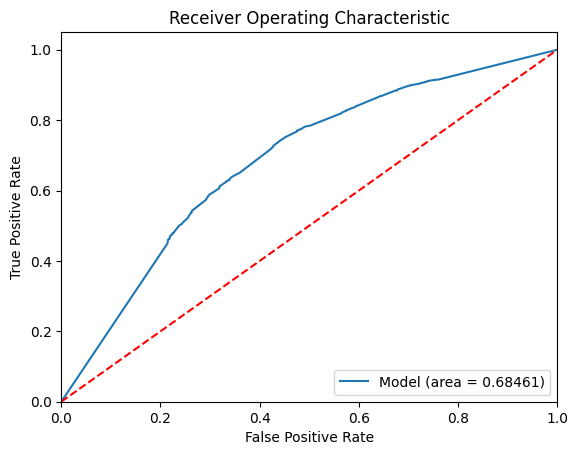

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
evaluate_model(dt_feat, X_train, y_train, X_valid, y_valid)

### Max-Depth Random Forest

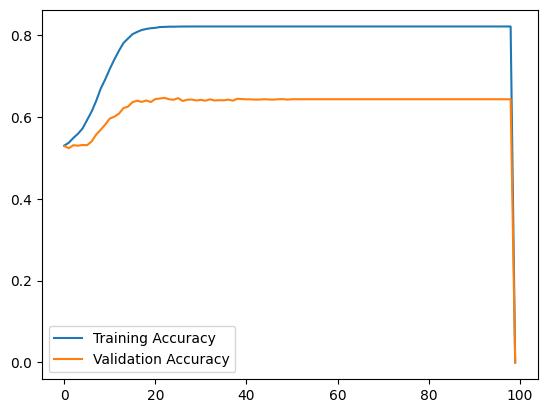

In [ ]:
forest_trainaccuracy = np.zeros(shape=(100))
forest_validaccuracy = np.zeros(shape=(100))
for max_d in range(1,100):
  rf = RandomForestClassifier(max_depth=max_d, random_state=42)
  rf.fit(X_train,y_train)
  forest_trainaccuracy[max_d - 1]= rf.score(X_train, y_train)
  forest_validaccuracy[max_d - 1]= rf.score(X_valid, y_valid)

depths = range(0, 100)

# Plot and label the training and validation loss values
plt.plot(depths, forest_trainaccuracy, label='Training Accuracy')
plt.plot(depths, forest_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

23
Accuracy on validation set: 0.64720812
True Neg: 1737 	 False Pos: 1218
False Neg: 867 	 True Pos: 2088
Precision on validation set: 0.63157895
Recall on validation set: 0.70659898
F1-Score on validation set: 0.66698610


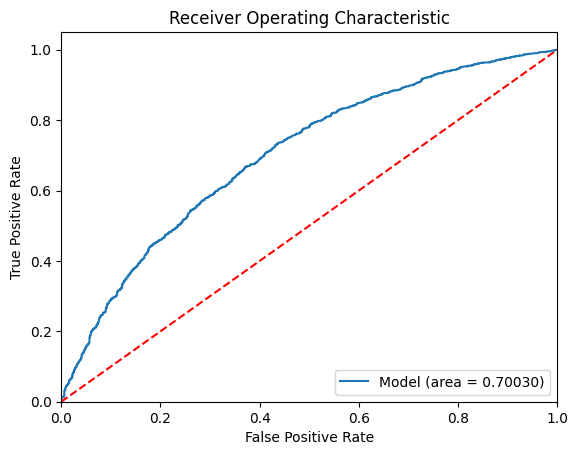

In [ ]:
# max_depth = sqrt(d)
d = forest_validaccuracy.argmax(axis=0) + 1
print(d)
rf_depth = RandomForestClassifier(max_depth=d)
evaluate_model(rf_depth, X_train, y_train, X_valid, y_valid)

### Random Forest Grid Search CV

Grid Search CV is done on the train data before oversampling, hence the code is not in this file

Accuracy on validation set: 0.64179357
True Neg: 1680 	 False Pos: 1275
False Neg: 842 	 True Pos: 2113
Precision on validation set: 0.62367178
Recall on validation set: 0.71505922
F1-Score on validation set: 0.66624626


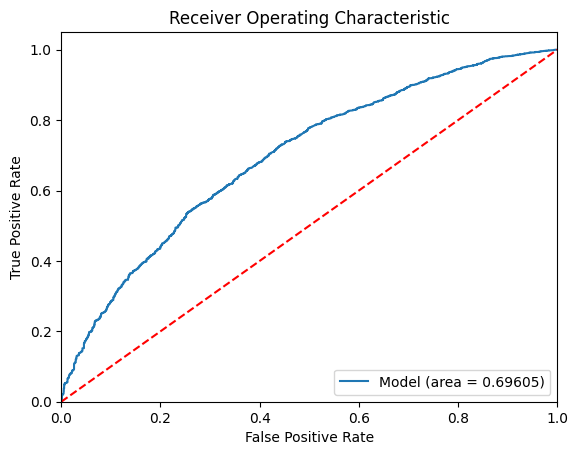

In [ ]:
rf_cvgrid = RandomForestClassifier(max_features=3, min_samples_leaf=3, min_samples_split=8,
                       n_estimators=200)
evaluate_model(rf_cvgrid, X_train, y_train, X_valid, y_valid)

### Random Forest Randomized Search CV

Randomnized Search CV is done on the train data before oversampling, hence the code is not in this file

Accuracy on validation set: 0.64873096
True Neg: 1700 	 False Pos: 1255
False Neg: 821 	 True Pos: 2134
Precision on validation set: 0.62968427
Recall on validation set: 0.72216582
F1-Score on validation set: 0.67276166


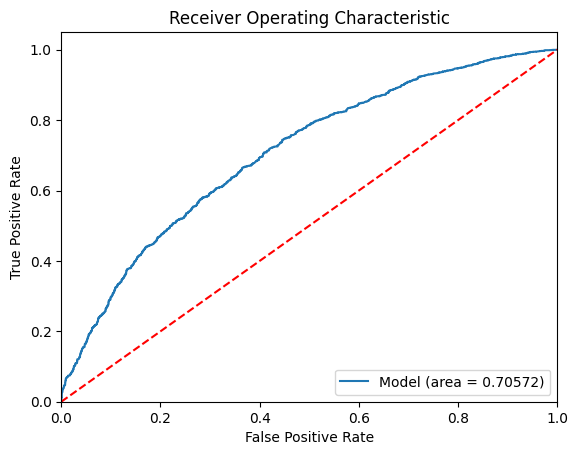

In [ ]:
rf_rscv = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
evaluate_model(rf_rscv, X_train, y_train, X_valid, y_valid)

## KNN

Accuracy on validation set: 0.61962775
True Neg: 1485 	 False Pos: 1470
False Neg: 778 	 True Pos: 2177
Precision on validation set: 0.59692898
Recall on validation set: 0.73671743
F1-Score on validation set: 0.65949712


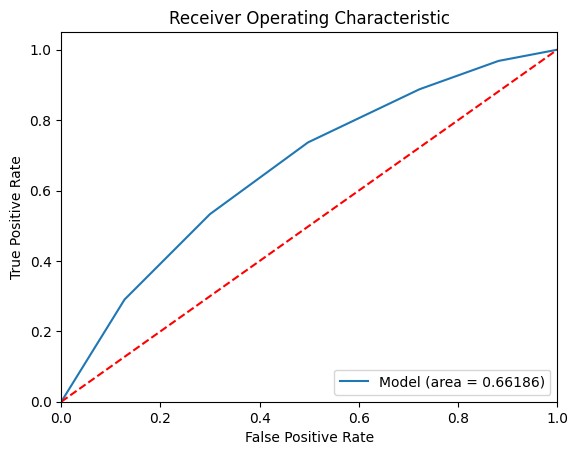

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
evaluate_model(knn_model, X_train, y_train, X_valid, y_valid)

### KNN: k values

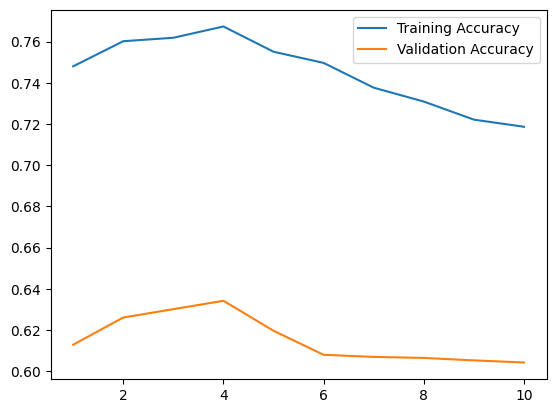

In [ ]:
kn_trainaccuracy = np.zeros(10)
kn_validaccuracy = np.zeros(10)
for k in range(1,11):
  kn = KNeighborsClassifier(n_neighbors=k)
  kn.fit(X_train,y_train)
  kn_trainaccuracy[k-1]= kn.score(X_train, y_train)
  kn_validaccuracy[k-1]= kn.score(X_valid, y_valid)

depths = range(1, 11)

# Plot and label the training and validation loss values
plt.plot(depths, kn_trainaccuracy, label='Training Accuracy')
plt.plot(depths, kn_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

4
Accuracy on validation set: 0.63417936
True Neg: 1831 	 False Pos: 1124
False Neg: 1038 	 True Pos: 1917
Precision on validation set: 0.63038474
Recall on validation set: 0.64873096
F1-Score on validation set: 0.63942628


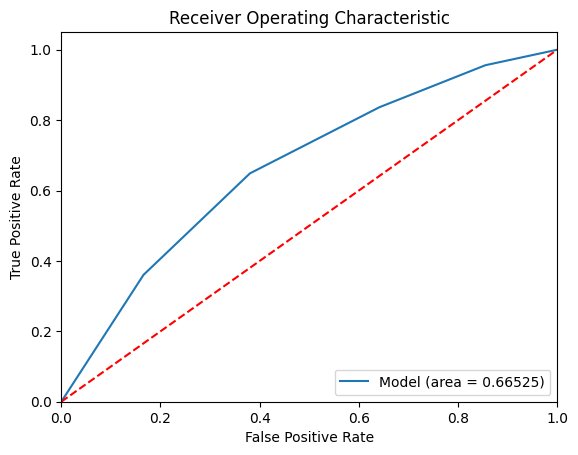

In [ ]:
k = kn_validaccuracy.argmax(axis=0) + 1
print(k)
knn_k = KNeighborsClassifier(n_neighbors=k)
evaluate_model(knn_k, X_train, y_train, X_valid, y_valid)

### KNN: feature selection

In [ ]:
from mlxtend.evaluate import PredefinedHoldoutSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

knn = KNeighborsClassifier(n_neighbors=4)

sfs1 = SFS(knn,
           k_features=3,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy')

sfs1 = sfs1.fit(X_train, y_train)



[2023-12-01 06:46:41] Features: 1/3 -- score: 0.6409045158160217
[2023-12-01 06:47:38] Features: 2/3 -- score: 0.6590424485020823
[2023-12-01 06:48:24] Features: 3/3 -- score: 0.6611570240237137

Selected features: (12, 14, 18)
Accuracy on validation set: 0.60812183
True Neg: 1772 	 False Pos: 1183
False Neg: 1133 	 True Pos: 1822
Precision on validation set: 0.60632280
Recall on validation set: 0.61658206
F1-Score on validation set: 0.61140940


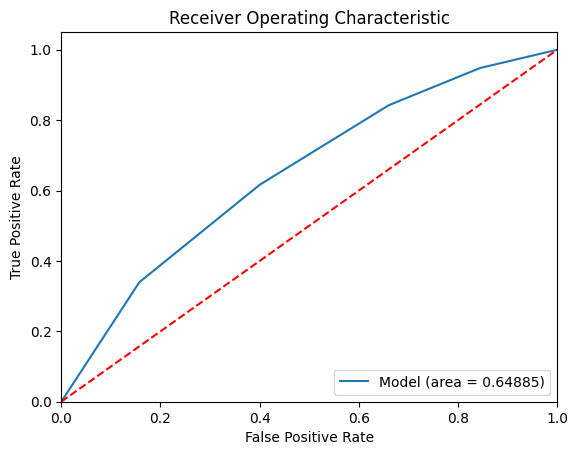

In [ ]:
print('Selected features:', sfs1.k_feature_idx_)
X_train_sfs = sfs1.transform(X_train)
X_valid_sfs = sfs1.transform(X_valid)
evaluate_model(knn, X_train_sfs, y_train, X_valid_sfs, y_valid)


## PCA/LDA/QDA/PLS

### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_valid)
pca_explained_variance = pca.explained_variance_ratio_

print(pca_explained_variance)

[9.85789626e-01 1.42091304e-02 1.23344433e-06 3.63034170e-09
 2.20866894e-09 1.25013779e-09 8.79980833e-10 4.84356582e-10
 4.52875198e-10 3.69099722e-10 3.29380796e-10 3.01305320e-10
 2.32598288e-10 1.98858574e-10 1.36091533e-10 1.07857181e-10
 7.88946949e-12 1.77753581e-17 2.16002190e-39]


First component explains about 98% of the variance, second component about 1.4%

In [ ]:
model_pca = PCA(n_components=2)
model_pca_X_train = model_pca.fit_transform(X_train)
model_pca_X_valid = model_pca.transform(X_valid)

Accuracy on validation set: 0.50118443
True Neg: 1126 	 False Pos: 1829
False Neg: 1119 	 True Pos: 1836
Precision on validation set: 0.50095498
Recall on validation set: 0.62131980
F1-Score on validation set: 0.55468278


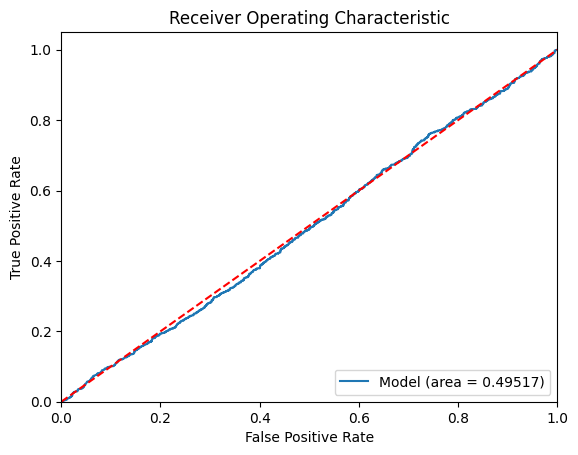

In [ ]:
pca_logReg = LogisticRegression()
evaluate_model(pca_logReg, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Accuracy on validation set: 0.52994924
True Neg: 1297 	 False Pos: 1658
False Neg: 1120 	 True Pos: 1835
Precision on validation set: 0.52533639
Recall on validation set: 0.62098139
F1-Score on validation set: 0.56916873


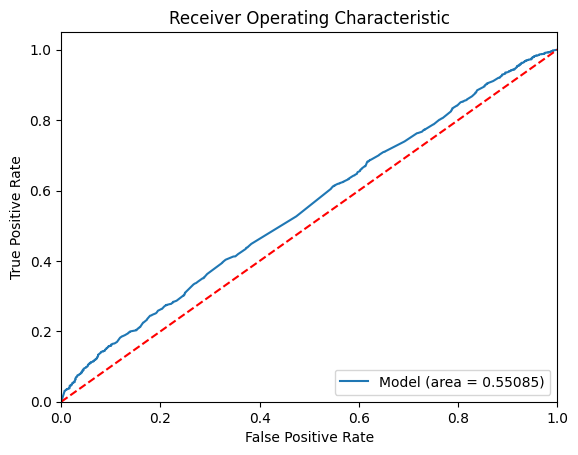

In [ ]:
pca_tree = RandomForestClassifier()
evaluate_model(pca_tree, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Performs more poorly

Accuracy on validation set: 0.61895093
True Neg: 1705 	 False Pos: 1250
False Neg: 1002 	 True Pos: 1953
Precision on validation set: 0.60974087
Recall on validation set: 0.66091371
F1-Score on validation set: 0.63429685


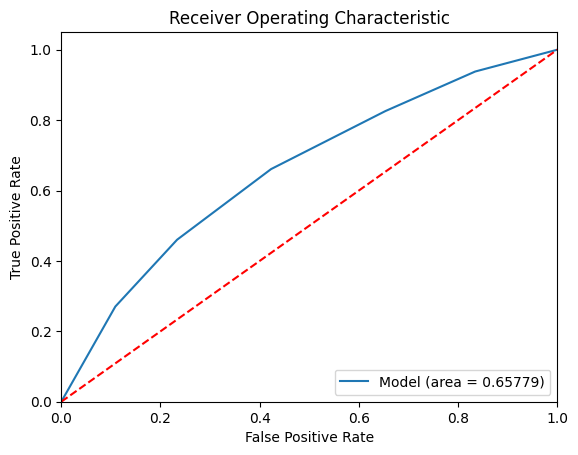

In [ ]:
pca_knn = KNeighborsClassifier()
evaluate_model(pca_knn, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

### LDA

Accuracy on validation set: 0.52774958
True Neg: 1457 	 False Pos: 1498
False Neg: 1293 	 True Pos: 1662
Precision on validation set: 0.52594937
Recall on validation set: 0.56243655
F1-Score on validation set: 0.54358136


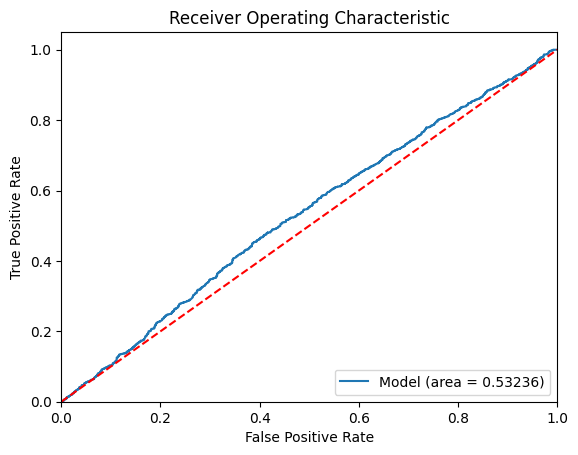

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
evaluate_model(lda, X_train, y_train, X_valid, y_valid)

### QDA

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy on validation set: 0.51218274
True Neg: 614 	 False Pos: 2341
False Neg: 542 	 True Pos: 2413
Precision on validation set: 0.50757257
Recall on validation set: 0.81658206
F1-Score on validation set: 0.62602153


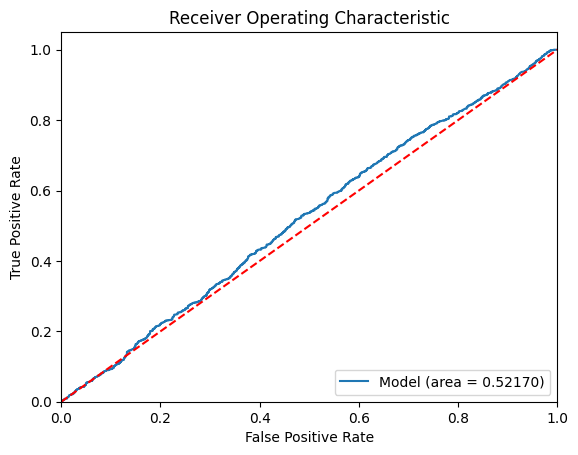

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
evaluate_model(qda, X_train, y_train, X_valid, y_valid)

### PLS

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls_binary = PLSRegression(n_components=2)
pls_binary.fit(X_train, y_train)

pls_ypred_raw = pls_binary.predict(X_valid)[:,0]
pls_ypred = (pls_binary.predict(X_valid)[:,0] > 0.5).astype('uint8')

print('Precision of PLS-DA classifier on test set: {:.2f}'.format(accuracy_score(y_valid, pls_ypred)))
print('Precision of PLS-DA classifier on test set: {:.2f}'.format(precision_score(y_valid, pls_ypred)))
print('Recall of PLS-DA classifier on test set: {:.2f}'.format(recall_score(y_valid, pls_ypred)))

Precision of PLS-DA classifier on test set: 0.53
Precision of PLS-DA classifier on test set: 0.52
Recall of PLS-DA classifier on test set: 0.56


## Naive Bayes

Accuracy on validation set: 0.51607445
True Neg: 1310 	 False Pos: 1645
False Neg: 1215 	 True Pos: 1740
Precision on validation set: 0.51403250
Recall on validation set: 0.58883249
F1-Score on validation set: 0.54889590


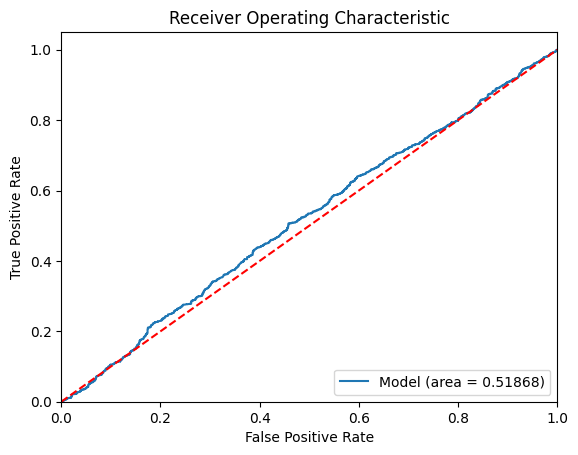

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
evaluate_model(nb_model, X_train, y_train, X_valid, y_valid)

## Boosting

### XGBOOST

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Accuracy on validation set: 0.60372250
True Neg: 1595 	 False Pos: 1360
False Neg: 982 	 True Pos: 1973
Precision on validation set: 0.59195920
Recall on validation set: 0.66768190
F1-Score on validation set: 0.62754453


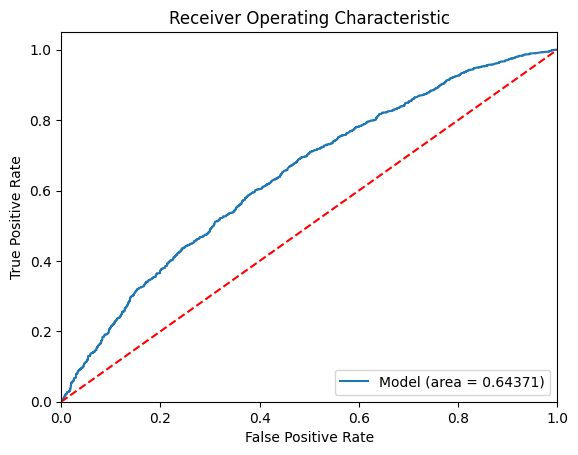

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective="multi:softmax", num_class=2)
evaluate_model(xgb_model, X_train, y_train, X_valid, y_valid)

### CatBoost

3030.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached catboost-1.2.2-cp310-cp310-macosx_11_0_universal2.whl (25.7 MB)

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
0:	learn: 0.6909918	total: 211ms	remaining: 1m 45s
1:	learn: 0.6889224	total: 325ms	remaining: 1m 20s
2:	learn: 0.6863539	total: 559ms	remaining: 1m 32s
3:	learn: 0.6843034	total: 672ms	remaining: 1m 23s
4:	learn: 0.6829070	total: 815ms	remaining: 1m 20s
5:	learn: 0.6815699	total: 867ms	remaining: 1m 11s
6:	learn: 0.6797648	total: 912ms	remaining: 1m 4s
7:	learn: 0.6781376	total: 976ms	remaining: 1m
8:	learn: 0.6769989	total: 1.1s	remaining: 1m
9:	learn: 0.6755681	total: 1.23s	remaining: 1m
10:	learn: 0.6742136	total: 1.29s	remaining: 57.4s
11:	learn: 0.6729033	total: 1.34s	remaining: 54.7s
12:	learn: 0.6705679	total: 1.39s	remaining: 52.2s
13:	learn: 0.6698370	total: 1.44s	remaining: 49.9s
14:	learn: 0.6687539	total: 1.49s	remaining: 48.1s
15:	learn: 0.6677255	total: 1.54s	remaining: 46.6s
16:	le

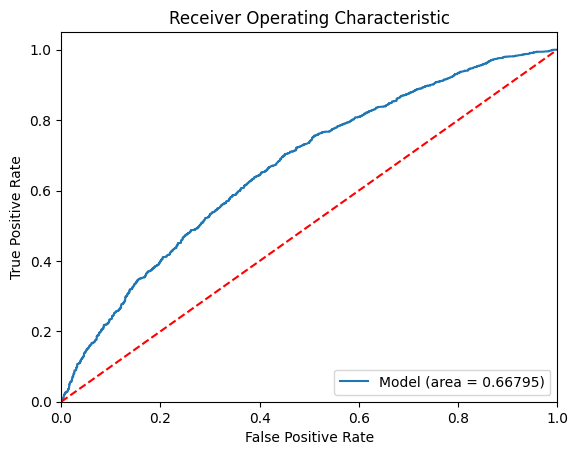

In [ ]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
evaluate_model(catboost_model, X_train, y_train, X_valid, y_valid)

### LGB

[LightGBM] [Info] Number of positive: 16788, number of negative: 16788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 33576, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy on validation set: 0.61099831
True Neg: 1537 	 False Pos: 1418
False Neg: 881 	 True Pos: 2074
Precision on validation set: 0.59392898
Recall on validation set: 0.70186125
F1-Score on validation set: 0.64340003


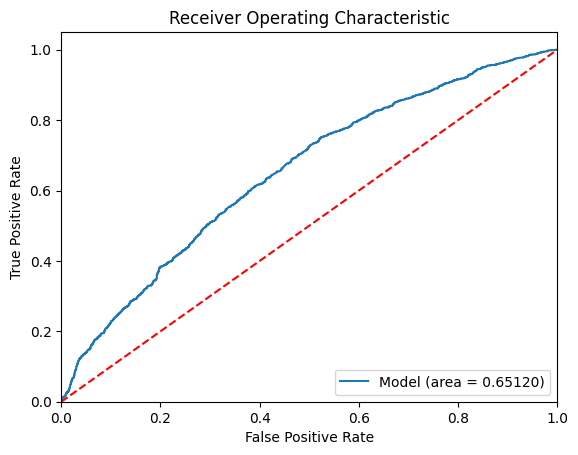

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)
evaluate_model(lgb_model, X_train, y_train, X_valid, y_valid)

## Ensemble Classifier

0:	learn: 0.6909918	total: 155ms	remaining: 1m 17s
1:	learn: 0.6889224	total: 278ms	remaining: 1m 9s
2:	learn: 0.6863539	total: 350ms	remaining: 58s
3:	learn: 0.6843034	total: 433ms	remaining: 53.7s
4:	learn: 0.6829070	total: 500ms	remaining: 49.5s
5:	learn: 0.6815699	total: 569ms	remaining: 46.8s
6:	learn: 0.6797648	total: 644ms	remaining: 45.3s
7:	learn: 0.6781376	total: 711ms	remaining: 43.8s
8:	learn: 0.6769989	total: 777ms	remaining: 42.4s
9:	learn: 0.6755681	total: 878ms	remaining: 43s
10:	learn: 0.6742136	total: 978ms	remaining: 43.5s
11:	learn: 0.6729033	total: 1.08s	remaining: 43.9s
12:	learn: 0.6705679	total: 1.18s	remaining: 44.1s
13:	learn: 0.6698370	total: 1.24s	remaining: 43s
14:	learn: 0.6687539	total: 1.27s	remaining: 41.2s
15:	learn: 0.6677255	total: 1.31s	remaining: 39.7s
16:	learn: 0.6657314	total: 1.35s	remaining: 38.3s
17:	learn: 0.6645728	total: 1.41s	remaining: 37.8s
18:	learn: 0.6631653	total: 1.6s	remaining: 40.6s
19:	learn: 0.6611875	total: 1.71s	remaining: 41

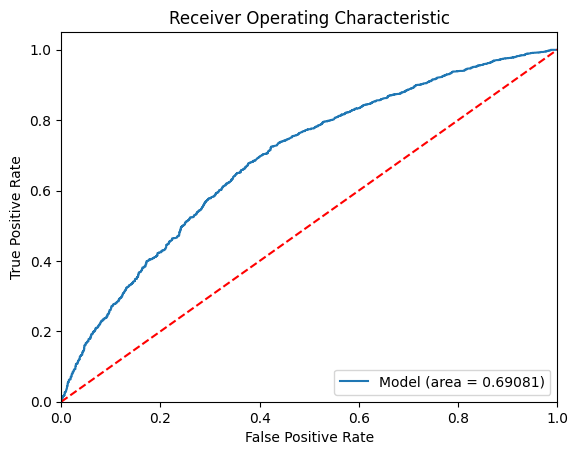

In [ ]:
# Ensemble with Default RF
from sklearn.ensemble import VotingClassifier

xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=500)
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
rf_model = RandomForestClassifier()
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('lgb', lgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model, X_train, y_train, X_valid, y_valid)

0:	learn: 0.6909918	total: 38ms	remaining: 19s
1:	learn: 0.6889224	total: 80.9ms	remaining: 20.1s
2:	learn: 0.6863539	total: 117ms	remaining: 19.4s
3:	learn: 0.6843034	total: 157ms	remaining: 19.5s
4:	learn: 0.6829070	total: 193ms	remaining: 19.1s
5:	learn: 0.6815699	total: 231ms	remaining: 19s
6:	learn: 0.6797648	total: 285ms	remaining: 20.1s
7:	learn: 0.6781376	total: 335ms	remaining: 20.6s
8:	learn: 0.6769989	total: 397ms	remaining: 21.7s
9:	learn: 0.6755681	total: 452ms	remaining: 22.1s
10:	learn: 0.6742136	total: 493ms	remaining: 21.9s
11:	learn: 0.6729033	total: 530ms	remaining: 21.6s
12:	learn: 0.6705679	total: 568ms	remaining: 21.3s
13:	learn: 0.6698370	total: 611ms	remaining: 21.2s
14:	learn: 0.6687539	total: 659ms	remaining: 21.3s
15:	learn: 0.6677255	total: 753ms	remaining: 22.8s
16:	learn: 0.6657314	total: 798ms	remaining: 22.7s
17:	learn: 0.6645728	total: 840ms	remaining: 22.5s
18:	learn: 0.6631653	total: 889ms	remaining: 22.5s
19:	learn: 0.6611875	total: 931ms	remaining: 

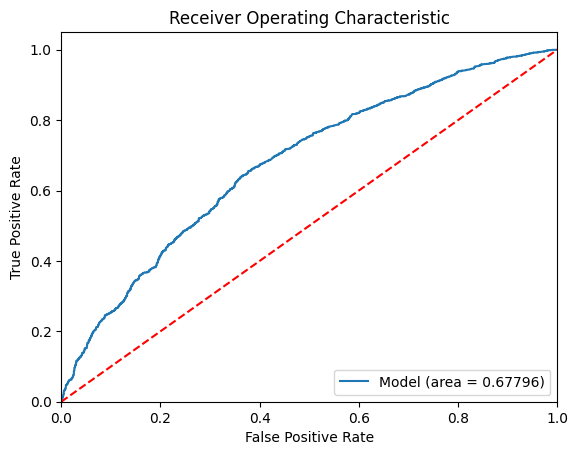

In [ ]:
# Ensemble with Grid Search CV RF
from sklearn.ensemble import VotingClassifier

xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=500)
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
rf_model = RandomForestClassifier(max_features=3, n_estimators=200, min_samples_leaf=3, min_samples_split=8)
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('lgb', lgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model, X_train, y_train, X_valid, y_valid)

0:	learn: 0.6909918	total: 86.7ms	remaining: 43.3s
1:	learn: 0.6889224	total: 140ms	remaining: 34.9s
2:	learn: 0.6863539	total: 195ms	remaining: 32.3s
3:	learn: 0.6843034	total: 270ms	remaining: 33.5s
4:	learn: 0.6829070	total: 334ms	remaining: 33.1s
5:	learn: 0.6815699	total: 379ms	remaining: 31.2s
6:	learn: 0.6797648	total: 435ms	remaining: 30.6s
7:	learn: 0.6781376	total: 487ms	remaining: 29.9s
8:	learn: 0.6769989	total: 545ms	remaining: 29.7s
9:	learn: 0.6755681	total: 603ms	remaining: 29.6s
10:	learn: 0.6742136	total: 654ms	remaining: 29.1s
11:	learn: 0.6729033	total: 715ms	remaining: 29.1s
12:	learn: 0.6705679	total: 812ms	remaining: 30.4s
13:	learn: 0.6698370	total: 962ms	remaining: 33.4s
14:	learn: 0.6687539	total: 1.05s	remaining: 34.1s
15:	learn: 0.6677255	total: 1.12s	remaining: 33.8s
16:	learn: 0.6657314	total: 1.18s	remaining: 33.5s
17:	learn: 0.6645728	total: 1.27s	remaining: 34.1s
18:	learn: 0.6631653	total: 1.33s	remaining: 33.7s
19:	learn: 0.6611875	total: 1.39s	remain

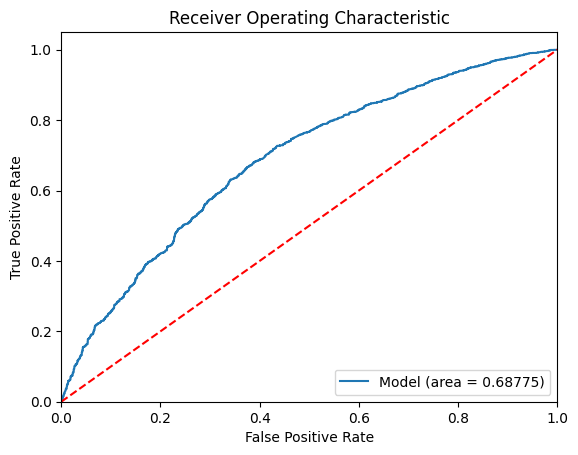

In [ ]:
# Ensemble with Randomnised Search CV RF
from sklearn.ensemble import VotingClassifier

xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=500)
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
rf_model = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('lgb', lgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model, X_train, y_train, X_valid, y_valid)

Accuracy on validation set: 0.64703892
True Neg: 1712 	 False Pos: 1243
False Neg: 843 	 True Pos: 2112
Precision on validation set: 0.62950820
Recall on validation set: 0.71472081
F1-Score on validation set: 0.66941363


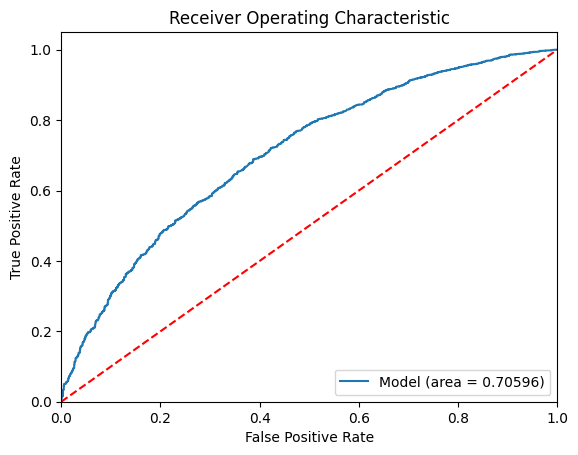

In [ ]:
# Ensemble with RFs
from sklearn.ensemble import VotingClassifier

rfscv = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
rfcv = RandomForestClassifier(max_features=3, n_estimators=200, min_samples_leaf=3, min_samples_split=8)
rf_model = RandomForestClassifier()

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('rfcv', rfcv),
    ('rfscv', rfscv)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model, X_train, y_train, X_valid, y_valid)

Accuracy on validation set: 0.62521151
True Neg: 1654 	 False Pos: 1301
False Neg: 914 	 True Pos: 2041
Precision on validation set: 0.61071215
Recall on validation set: 0.69069374
F1-Score on validation set: 0.64824520


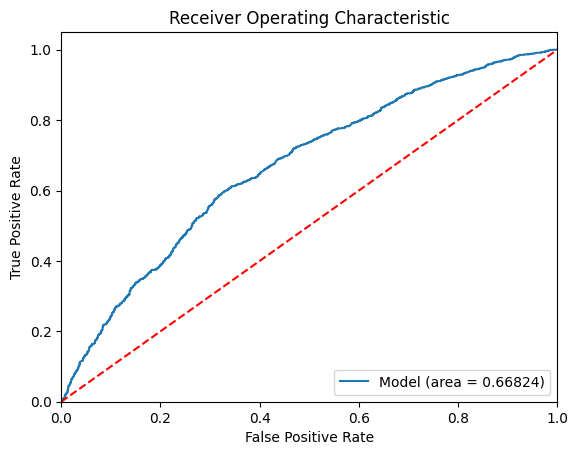

In [ ]:
xgb_model_1 = XGBClassifier(learning_rate=0.1, n_estimators=1000)
xgb_model_2 = XGBClassifier(learning_rate=0.05, n_estimators=2000)
xgb_model_3 = XGBClassifier(learning_rate=0.01, n_estimators=3000)

# Create an ensemble model using VotingClassifier
ensemble_xgb = VotingClassifier(estimators=[
    ('xgb_1', xgb_model_1),
    ('xgb_2', xgb_model_2),
    ('xgb_3', xgb_model_3)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_xgb, X_train, y_train, X_valid, y_valid)

0:	learn: 0.6916114	total: 19.8ms	remaining: 19.8s
1:	learn: 0.6906651	total: 34.6ms	remaining: 17.3s
2:	learn: 0.6898464	total: 45.8ms	remaining: 15.2s
3:	learn: 0.6889482	total: 54.1ms	remaining: 13.5s
4:	learn: 0.6880995	total: 68ms	remaining: 13.5s
5:	learn: 0.6872641	total: 92.4ms	remaining: 15.3s
6:	learn: 0.6866480	total: 100ms	remaining: 14.2s
7:	learn: 0.6860664	total: 112ms	remaining: 13.9s
8:	learn: 0.6851722	total: 121ms	remaining: 13.3s
9:	learn: 0.6843968	total: 129ms	remaining: 12.8s
10:	learn: 0.6839890	total: 138ms	remaining: 12.4s
11:	learn: 0.6832928	total: 147ms	remaining: 12.1s
12:	learn: 0.6826632	total: 155ms	remaining: 11.8s
13:	learn: 0.6820865	total: 166ms	remaining: 11.7s
14:	learn: 0.6818027	total: 174ms	remaining: 11.4s
15:	learn: 0.6814023	total: 187ms	remaining: 11.5s
16:	learn: 0.6810350	total: 196ms	remaining: 11.3s
17:	learn: 0.6806646	total: 205ms	remaining: 11.2s
18:	learn: 0.6798457	total: 215ms	remaining: 11.1s
19:	learn: 0.6795037	total: 225ms	rem

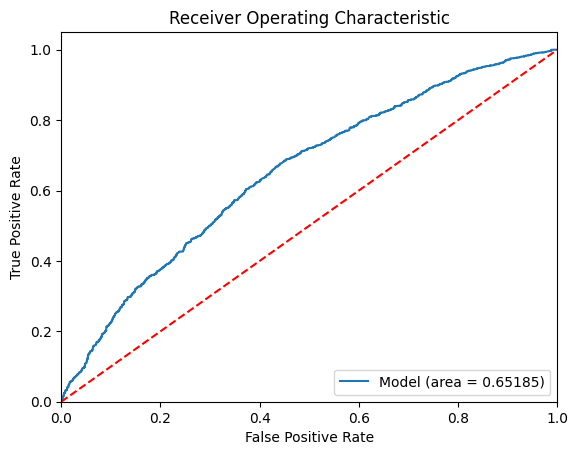

In [ ]:
catboost_model_1 = CatBoostClassifier(learning_rate=0.1, n_estimators=1000)
catboost_model_2 = CatBoostClassifier(learning_rate=0.05, n_estimators=2000)
catboost_model_3 = CatBoostClassifier(learning_rate=0.01, n_estimators=3000)

# Create an ensemble model using VotingClassifier
ensemble_cb = VotingClassifier(estimators=[
    ('cb_1', catboost_model_1),
    ('cb_2', catboost_model_2),
    ('cb_3', catboost_model_3)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_cb, X_train, y_train, X_valid, y_valid)

[LightGBM] [Info] Number of positive: 16788, number of negative: 16788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 33576, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 16788, number of negative: 16788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 33576, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

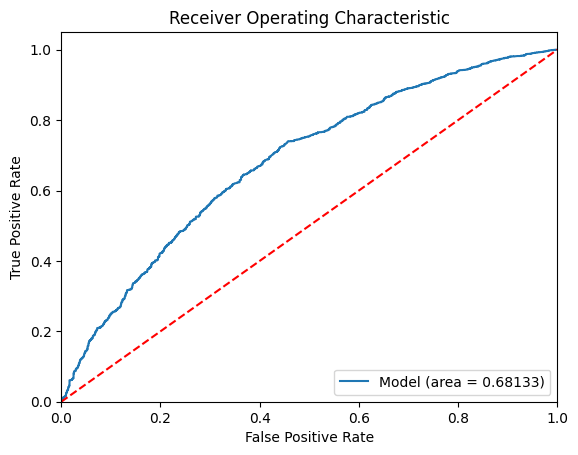

In [ ]:
from lightgbm import LGBMClassifier
lgb_model_1 = LGBMClassifier(learning_rate=0.1, n_estimators=1000)
lgb_model_2 = LGBMClassifier(learning_rate=0.05, n_estimators=2000)
lgb_model_3 = LGBMClassifier(learning_rate=0.01, n_estimators=3000)

# Create an ensemble model using VotingClassifier
ensemble_lgb = VotingClassifier(estimators=[
    ('lgb_1', lgb_model_1),
    ('lgb_2', lgb_model_2),
    ('lgb_3', lgb_model_3)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_lgb, X_train, y_train, X_valid, y_valid)